In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import _tconfint_generic,_zconfint_generic
from statsmodels.stats.proportion import proportion_confint
import scipy
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.model_selection import cross_val_score,StratifiedKFold,GridSearchCV, cross_validate
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression,RidgeClassifier
from scipy import hstack
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
import warnings
warnings.filterwarnings('ignore')

C:\Users\wild-moray\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Populating the interactive namespace from numpy and matplotlib


Функция для построения кривых валидации:

In [2]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


    Доверительный интервал для средней цены билета

In [4]:
_tconfint_generic(alpha=0.05,alternative='two-sided',dof=len(train)-1,mean=train.Fare.mean(),
                  std_mean=train.Fare.std(ddof=1)/np.sqrt(len(train)))

(28.936831234567297, 35.47158470258191)

In [5]:
y=train.Survived.values
train.drop('Survived', inplace=True, axis=1)
train_test=pd.concat([train,test])
train_test.drop(['PassengerId','Ticket','Cabin'],axis=1,inplace=True)

In [6]:
len(y[y==1]), len(y[y==0])

(342, 549)

В выборке значительно больше примеров невыживших пассажиров, необходимо будет стратифицировать при обучении

In [7]:
train_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [8]:
train_test.describe()

,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


In [9]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 8 columns):
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Fare        1308 non-null float64
Embarked    1307 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 92.0+ KB


Есть незаполненные значения для возраста, стоимости билета и пункта отбытия пассажира. Заполним возраст медианным значением по выборке, пункт отбытия - модой, стоимость - медианой

In [10]:
train_test['Age'].fillna(train_test['Age'].median(),inplace=True)
train_test['Embarked'].fillna(train_test['Embarked'].mode()[0],inplace=True)
train_test['Fare'].fillna(train_test['Fare'].median(),inplace=True)

In [11]:
train_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


Признак пол категориальный, добавим вместо него бинарные признаки: мужчина и женщина. Также есть два признака SibSp и Parch, которые определяют был человек на борту один или с супругом/детьми/братьями/сестрами. Определим также два бинарных признака: один/в сопровождении. Признак Name содержит семейный статус, выделим только его.

In [12]:
train_test['Male']= list(map(lambda x: 1 if x=='male' else 0,train_test['Sex']))
train_test['Female']= list(map(lambda x: 1 if x=='female' else 0,train_test['Sex']))
train_test['Title'] = train_test['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
train_test['Alone']= list(map(lambda x,y: 0 if x+y>0 else 1,train_test['SibSp'],train_test['Parch']))
train_test['Not_Alone']= list(map(lambda x,y: 0 if x+y==0 else 1,train_test['SibSp'],train_test['Parch']))

Применим кодирование для признаков Title, Embarked и Pclass, а признаки Age и Fare масштабируем

In [13]:
unique(train_test['Title'].values)

array(['Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major',
       'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir',
       'the Countess'], dtype=object)

In [14]:
title_names = (train_test['Title'].value_counts() < 10)
train_test['Title'] = train_test['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

In [15]:
unique(train_test['Title'].values)

array(['Master', 'Misc', 'Miss', 'Mr', 'Mrs'], dtype=object)

In [16]:
label_code=LabelEncoder()
train_test['Title']=label_code.fit_transform(train_test['Title'].values)
train_test['Embarked']=label_code.fit_transform(train_test['Embarked'].values)

In [17]:
onehot=OneHotEncoder()
scaler=StandardScaler()
for_code=train_test[['Title','Embarked','Pclass']]
code=onehot.fit_transform(for_code.values)
train_test['Fare']=scaler.fit_transform(train_test['Fare'].values.reshape(-1, 1))
train_test['Age']=scaler.fit_transform(train_test['Age'].values.reshape(-1, 1))

In [18]:
X_train_test=hstack([train_test[['Age','Fare','Male','Female','Alone','Not_Alone']].values,code.toarray()])
X_train=X_train_test[:train.shape[0]]
X_test=X_train_test[train.shape[0]:]

Посмотрим на корреляцию признаков и целевой метки

In [19]:
train_new=train_test.iloc[:train.shape[0]]
train_new['survived']=y

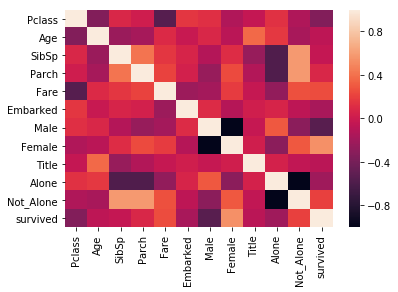

In [20]:
sns.heatmap(train_new.corr())

Из матрицы видно, что целевая метка сильнее всего коррелирует с классом обсуживания, а также полом пассажира

Построим гистограмму выживаемости пассажиров в зависимости от класса обслуживания

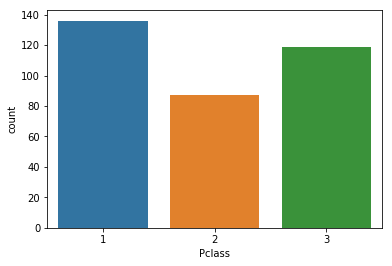

In [21]:
sns.countplot(train_new.Pclass[train_new['survived']==1])

In [22]:
train_new.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Как и ожидалось, из гистограммы видно, что пассажиры первого класса выживали чаще других, "проседание" 2 класса обусловлено меньшим содержанием пассажиров этого класса в выборке.

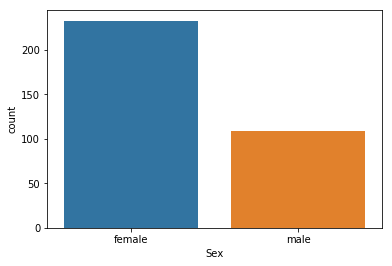

In [23]:
sns.countplot(train.Sex[train_new.survived==1])

Из следующей диаграммы видно, что пассажиры женского пола выживали значительно чаще пассажиров мужского пола

Проверим, что выживаемость среди одиноких пассажиров и пассажиров, путешествовавших с семьей, не отличается. Интервальные оценки для долей:

In [24]:
conf_interval_alone = proportion_confint(sum(train_new.Alone), 
                                            train_new.shape[0],
                                            method = 'wilson')
conf_interval_not_alone = proportion_confint(sum(train_new.Not_Alone), 
                                            train_new.shape[0],
                                            method = 'wilson')
print('95%% confidence interval for a survival, alone: [%f, %f]' % conf_interval_alone)
print('95%% confidence interval for a survival, not alone [%f, %f]' % conf_interval_not_alone)

95% confidence interval for a survival, alone: [0.570188, 0.634317]
95% confidence interval for a survival, not alone [0.365683, 0.429812]


In [25]:
#функция для расчета доверительного интервала разности долей независимых выборок
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [26]:
#функция для расчета z-статистики
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [27]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [28]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(train_new.Alone, train_new.Not_Alone))

95% confidence interval for a difference between proportions: [0.159948, 0.250827]


In [29]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(train_new.Alone, train_new.Not_Alone), 'greater'))

p-value: 0.000000


Перейдем к обучению моделей

In [30]:
stf=StratifiedKFold(n_splits=10,shuffle=True)
ML_alg=[SGDClassifier(),RidgeClassifier(),LogisticRegression(),
       DecisionTreeClassifier(),RandomForestClassifier(),BaggingClassifier(),
       XGBClassifier(), GradientBoostingClassifier(), BernoulliNB(),
       KNeighborsClassifier(), LinearSVC()]
MLA_columns = ['ML_alg', 'Parameters']
MLA_compare = pd.DataFrame(columns = MLA_columns)


row_index = 0
for alg in ML_alg:
    ML_alg = alg.__class__.__name__
    MLA_compare.loc[row_index, 'ML_alg'] = ML_alg
    MLA_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    cv_results = cross_validate(alg, X_train, y, cv  = stf)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   
    
    row_index+=1
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,ML_alg,Parameters,MLA Time,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD
6,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.149845,0.886644,0.831630,0.129870
7,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.157728,0.905724,0.827049,0.127213
5,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.036995,0.966580,0.804778,0.084214
2,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.003624,0.814440,0.803553,0.074839
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.027256,0.966205,0.802580,0.103418
3,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.003716,0.983165,0.800207,0.099939
9,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.001868,0.865693,0.800155,0.119081
10,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.087600,0.807955,0.796912,0.101884
1,RidgeClassifier,"{'alpha': 1.0, 'class_weight': None, 'copy_X':...",0.003867,0.806208,0.796797,0.086060
8,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.002087,0.794738,0.791382,0.164239


Лучший результат показал градиентный бустинг, попробуем подобрать параметры алгоритма по сетке для улучшения результата

In [32]:
xgb=XGBClassifier()
l_rate=np.linspace(0.5, 3,10)
base_score=np.linspace(0.2, 0.8,10)
depth=np.linspace(3,50,20).astype('int')
searcher=GridSearchCV(cv=stf,estimator=xgb,scoring='accuracy',param_grid={'max_depth': depth, 'base_score': base_score,
                                                                         'learning_rate': l_rate})

In [33]:
searcher.fit(X_train,y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 3,  5,  7, 10, 12, 15, 17, 20, 22, 25, 27, 30, 32, 35, 37, 40, 42,
       45, 47, 50]), 'base_score': array([0.2    , 0.26667, 0.33333, 0.4    , 0.46667, 0.53333, 0.6    ,
       0.66667, 0.73333, 0.8    ]), 'learning_rate': array([0.5    , 0.77778, 1.05556, 1.33333, 1.61111, 1.88889, 2.16667,
       2.44444, 2.72222, 3.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',


In [34]:
searcher.best_params_

{'base_score': 0.4, 'learning_rate': 0.5, 'max_depth': 3}

In [35]:
searcher.best_score_

0.8338945005611672

Кривая валидации для глубины базовых деревьев в градиентном бустинге

C:\Users\wild-moray\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\wild-moray\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


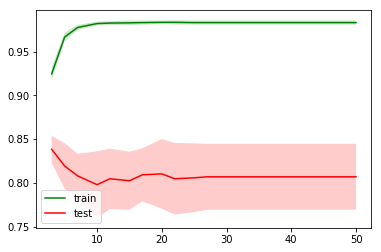

In [127]:
plot_validation_curves(depth,searcher.cv_results_)